In [ ]:
###############################################################################
# 0. Chargement des librairies
###############################################################################
library(glmnet)
library(corrplot)
library(pheatmap)
library(FactoMineR)
library(factoextra)
library(caret)


par(bg = "white")  # Style graphique global


###############################################################################
# 1. Extraction des données brutes
###############################################################################
data_weather <- read.table("data/donnees-synop-essentielles-omm.csv",
                        header = TRUE,
                        sep = ";",
                        quote = "\"")

cat("Dimensions initiales :", dim(data_weather), "\n")
summary(data_weather)

# ###############################################################################
# # 2. Filtrage — Focus sur une station météo (Nice, ID = 7181)
# ###############################################################################
# data_weather_nice <- data_weather[data_weather$ID.OMM.station == "7181", ]

# cat("Dimensions après filtrage station 7181 :", dim(data_weather_nice), "\n")


###############################################################################
# 3. Nettoyage — Garder uniquement les colonnes numériques + imputation NA
###############################################################################
# Sélection numérique uniquement
df_num <- data_weather_nice[, sapply(data_weather_nice, is.numeric)]

# Suppression des colonnes constantes (variance nulle)
df_num <- df_num[, apply(df_num, 2, function(x) length(unique(na.omit(x))) > 1)]

# Imputation des NA par la moyenne
for (col in names(df_num)) {
  df_num[is.na(df_num[[col]]), col] <- mean(df_num[[col]], na.rm = TRUE)
}

cat("Dimensions après nettoyage :", dim(df_num), "\n")

#TODO : A AMELIORER AVEC CODE DE JULES 




Loading required package: lattice



Dimensions initiales : 1719567 82 


 ID.OMM.station      Date           Pression.au.niveau.mer
 Min.   : 7005   Length:1719567     Min.   : 93850        
 1st Qu.: 7207   Class :character   1st Qu.:101180        
 Median : 7577   Mode  :character   Median :101600        
 Mean   :26062                      Mean   :101577        
 3rd Qu.:61976                      3rd Qu.:102090        
 Max.   :89642                      Max.   :107570        
                                    NA's   :94370         
 Variation.de.pression.en.3.heures Type.de.tendance.barométrique
 Min.   :-2840.00                  Min.   : 0.000               
 1st Qu.:  -60.00                  1st Qu.: 2.000               
 Median :   10.00                  Median : 3.000               
 Mean   :   15.39                  Mean   : 4.297               
 3rd Qu.:   90.00                  3rd Qu.: 7.000               
 Max.   : 2990.00                  Max.   :10.000               
 NA's   :40694                     NA's   :68236                
 Directi

Dimensions après filtrage station 7181 : 29310 82 
Dimensions après nettoyage : 29310 42 



Top corrélations toutes variables confondues (>| 0.3 |):
                                                 var1
53                                        Température
62                 Température.minimale.sur.12.heures
69                 Température.maximale.sur.12.heures
77          Température.minimale.du.sol.sur.12.heures
12                             Pression.au.niveau.mer
28                        Vitesse.du.vent.moyen.10.mn
49 Hauteur.de.la.base.des.nuages.de.l.étage.inférieur
33                Rafale.sur.les.10.dernières.minutes
31                        Vitesse.du.vent.moyen.10.mn
22                 Température.minimale.sur.12.heures
63                 Température.maximale.sur.12.heures
68                 Température.minimale.sur.12.heures
72            Température.minimale.sur.12.heures...C.
24                                     Point.de.rosée
74                                     Point.de.rosée
                                                var2  corr
53                 

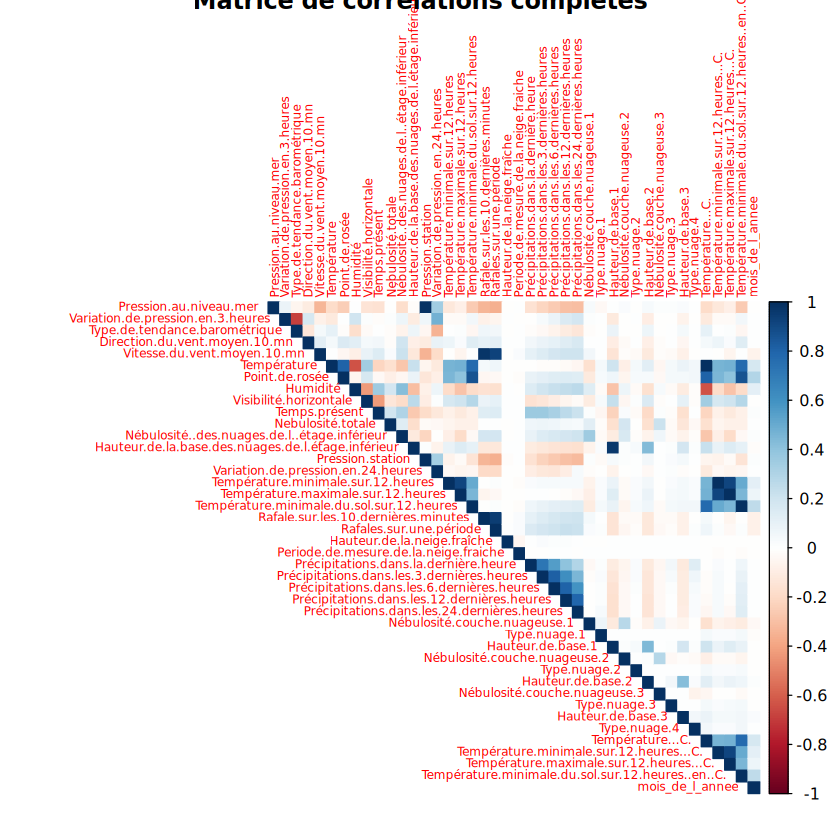


Variables forte cor ou redondante (>0.8) à fusionner / réduire :
 [1] "Température"                                       
 [2] "Température...C."                                  
 [3] "Température.minimale.du.sol.sur.12.heures"         
 [4] "Température.minimale.du.sol.sur.12.heures..en..C." 
 [5] "Température.maximale.sur.12.heures"                
 [6] "Température.maximale.sur.12.heures...C."           
 [7] "Température.minimale.sur.12.heures...C."           
 [8] "Précipitations.dans.les.12.dernières.heures"       
 [9] "Précipitations.dans.les.6.dernières.heures"        
[10] "Pression.au.niveau.mer"                            
[11] "Rafales.sur.une.période"                           
[12] "Hauteur.de.la.base.des.nuages.de.l.étage.inférieur"
[13] "Rafale.sur.les.10.dernières.minutes"               

Corrélations négatives fortes :
                                var1                          var2   corr
1  Variation.de.pression.en.3.heures Type.de.tendance.barométrique -0.681

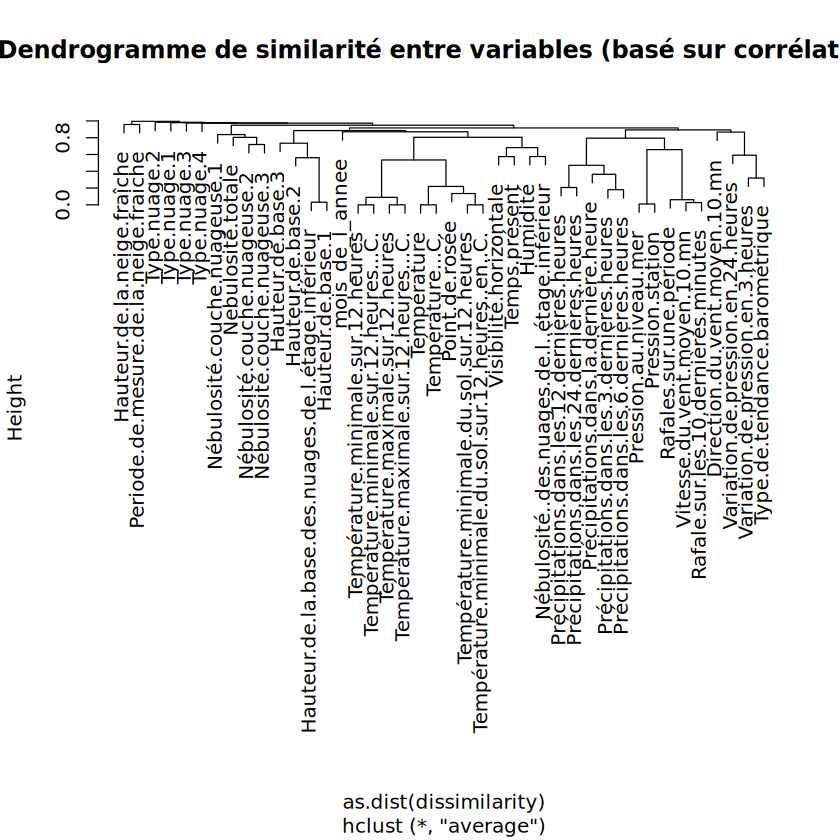

In [9]:
###############################################################################
# 4. Analyse des corrélations structurée
###############################################################################
par(bg = "white")

# 4.1 Corrélation brute + Heatmap
cor_mat <- cor(df_num, use = "pairwise.complete.obs")
corrplot(cor_mat, method = "color", type = "upper", tl.cex = 0.6,
         main = "Matrice de corrélations complètes")

# 4.2 Extraction des corrélations fortes (positives & négatives)
cor_threshold <- 0.3
cor_mat_abs <- abs(cor_mat)
cor_mat_abs[lower.tri(cor_mat_abs, diag = TRUE)] <- 0

strong_corr <- which(cor_mat_abs > cor_threshold, arr.ind = TRUE)

corr_df <- data.frame(
  var1 = rownames(cor_mat_abs)[strong_corr[,1]],
  var2 = colnames(cor_mat_abs)[strong_corr[,2]],
  corr = round(cor_mat[strong_corr], 3)
)

corr_df <- corr_df[order(-abs(corr_df$corr)), ]
cat("\nTop corrélations toutes variables confondues (>|",cor_threshold,"|):\n")
print(head(corr_df, 15))

# 4.3 Arbre hiérarchique des variables selon corrélation
dissimilarity <- 1 - abs(cor_mat)     # distance = 1 - |corr|
hc <- hclust(as.dist(dissimilarity), method = "average")

plot(hc, main = "Dendrogramme de similarité entre variables (basé sur corrélation)")

# 4.4 Analyse des redondances et oppositions
high_corr_groups <- findCorrelation(cor_mat, cutoff = 0.8)
cat("\nVariables forte cor ou redondante (>0.8) à fusionner / réduire :\n")
print(names(df_num)[high_corr_groups])

neg_corr <- subset(corr_df, corr < -0.4)
cat("\nCorrélations négatives fortes :\n")
print(neg_corr)

# 4.5 (OPTIONNEL) Version filtrée des corrélations non triviales
filter_patterns <- c("Pression", "Précipitations", "Température")
corr_df_filtered <- subset(corr_df,
                           !grepl(paste(filter_patterns, collapse="|"), var1) &
                           !grepl(paste(filter_patterns, collapse="|"), var2))

cat("\nCorrélations (hors Temp, pression, precipitaiton) :\n")
print(head(corr_df_filtered, 10))




In [10]:
###############################################################################
# 4bis. Filtrage grâce à la correlation 
###############################################################################

###############################################################################
# 2. Filtrage — Focus sur une station météo (Nice, ID = 7181)
###############################################################################

selected_data <- data_weather[, c(1,2,3,7,8,9,10,11,15,17,23,37,71,72,73)]

data_weather_nice <- selected_data[selected_data$ID.OMM.station == "7181", ]

cat("Dimensions après filtrage station 7181 :", dim(data_weather_nice), "\n")


###############################################################################
# 3. Nettoyage — Garder uniquement les colonnes numériques + imputation NA
###############################################################################
# Sélection numérique uniquement
df_num <- data_weather_nice[, sapply(data_weather_nice, is.numeric)]

# Suppression des colonnes constantes (variance nulle)
df_num <- df_num[, apply(df_num, 2, function(x) length(unique(na.omit(x))) > 1)]

# Imputation des NA par la moyenne
for (col in names(df_num)) {
  df_num[is.na(df_num[[col]]), col] <- mean(df_num[[col]], na.rm = TRUE)
}

cat("Dimensions après nettoyage :", dim(df_num), "\n")





Dimensions après filtrage station 7181 : 29310 15 
Dimensions après nettoyage : 29310 9 


,Pression.au.niveau.mer,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Nebulosité.totale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Hauteur.de.la.neige.fraîche
Pression.au.niveau.mer,1.00,-0.34,-0.19,-0.24,0.01,-0.14,0.00,-0.02,-0.01
Vitesse.du.vent.moyen.10.mn,-0.34,1.00,0.00,-0.04,-0.08,0.09,0.02,-0.13,0.00
Température,-0.19,0.00,1.00,0.80,-0.63,0.35,-0.16,0.23,-0.01
Point.de.rosée,-0.24,-0.04,0.80,1.00,-0.06,0.18,-0.08,0.08,-0.01
Humidité,0.01,-0.08,-0.63,-0.06,1.00,-0.42,0.19,-0.31,0.01
Visibilité.horizontale,-0.14,0.09,0.35,0.18,-0.42,1.00,-0.14,0.27,0.01
Nebulosité.totale,0.00,0.02,-0.16,-0.08,0.19,-0.14,1.00,-0.17,0.00
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,-0.02,-0.13,0.23,0.08,-0.31,0.27,-0.17,1.00,0.00
Hauteur.de.la.neige.fraîche,-0.01,0.00,-0.01,-0.01,0.01,0.01,0.00,0.00,1.00


Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.5917 1.1841 1.0940 1.0001 0.94783 0.90154 0.79848
Proportion of Variance 0.2815 0.1558 0.1330 0.1111 0.09982 0.09031 0.07084
Cumulative Proportion  0.2815 0.4373 0.5703 0.6814 0.78123 0.87154 0.94238
                           PC8     PC9
Standard deviation     0.71589 0.07809
Proportion of Variance 0.05694 0.00068
Cumulative Proportion  0.99932 1.00000


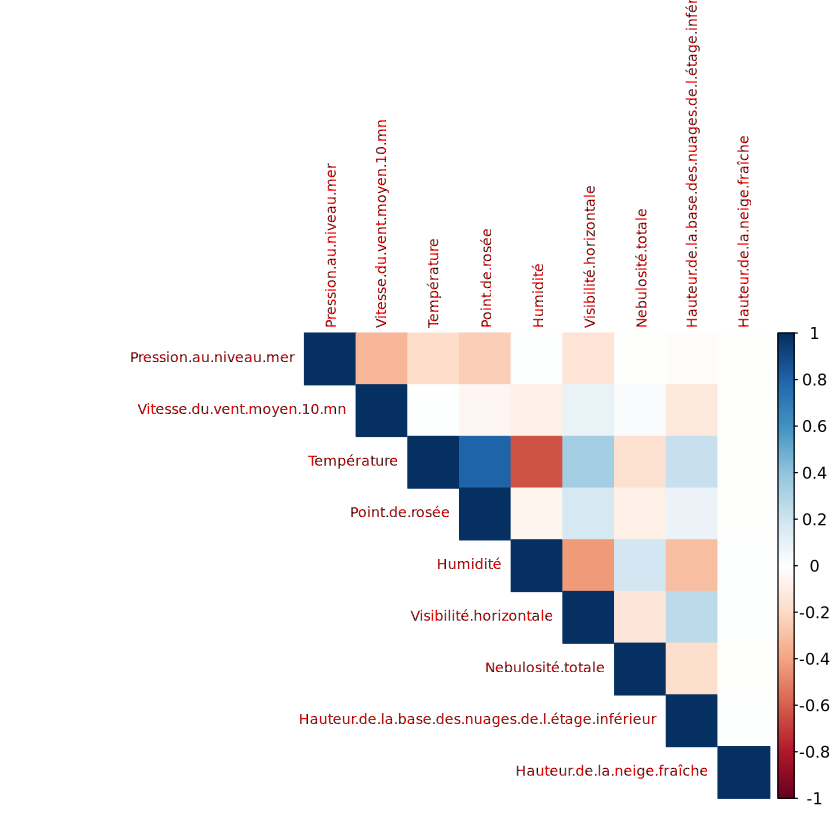

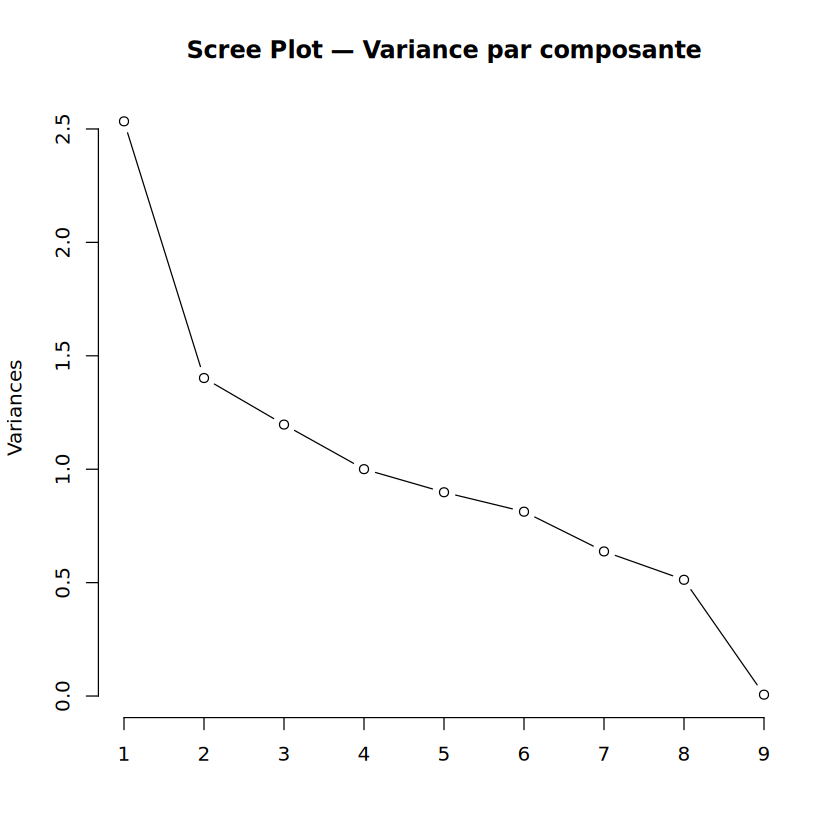

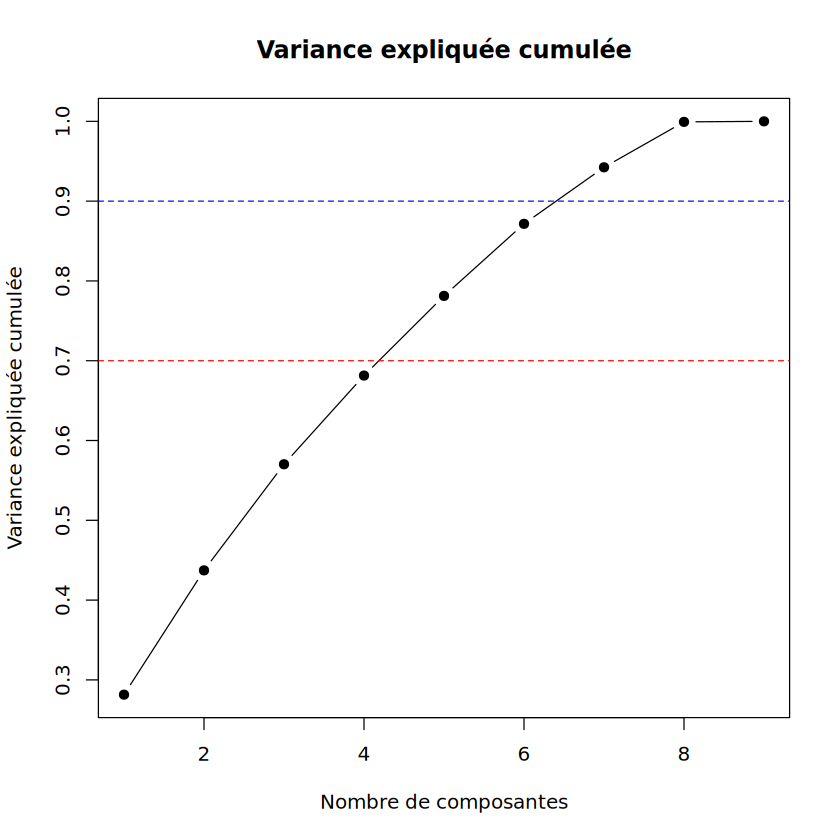


PC1 est principalement défini par :
                                       Température 
                                       0.571277136 
                                          Humidité 
                                       0.441248442 
                                    Point.de.rosée 
                                       0.413047563 
                            Visibilité.horizontale 
                                       0.386344798 
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur 
                                       0.282919069 
                                 Nebulosité.totale 
                                       0.203084125 
                            Pression.au.niveau.mer 
                                       0.187373670 
                       Vitesse.du.vent.moyen.10.mn 
                                       0.051651191 
                       Hauteur.de.la.neige.fraîche 
                                       0.002924735 
                           

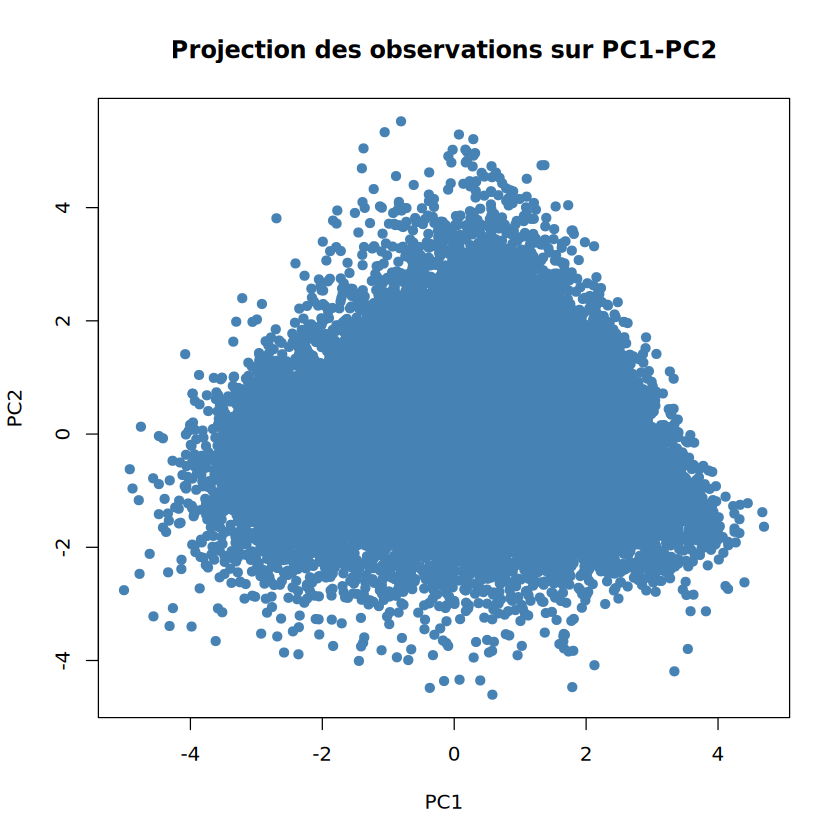

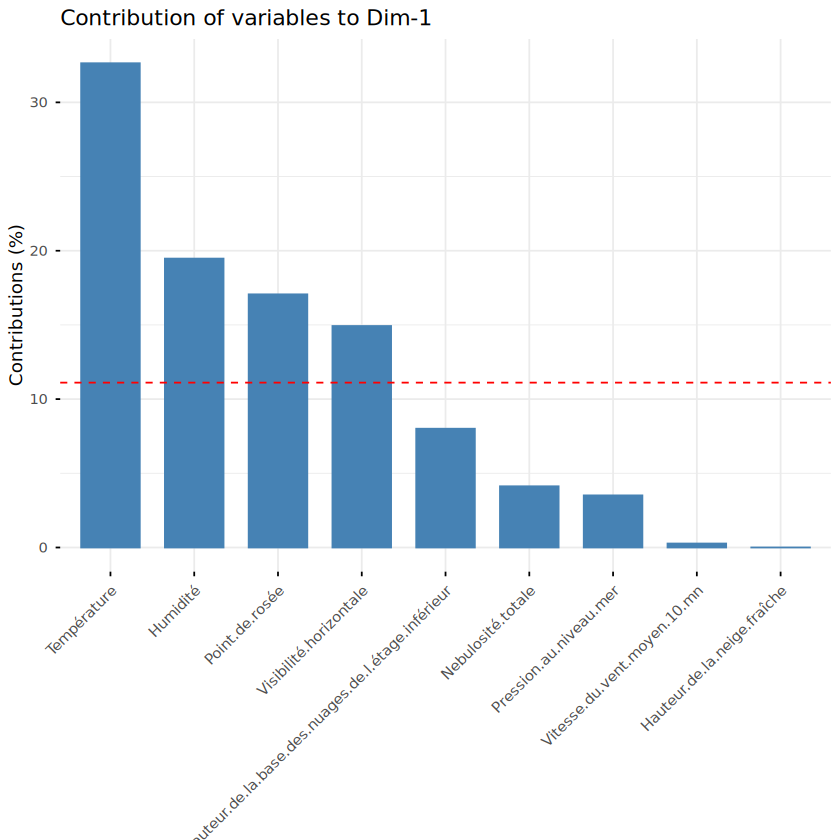


⚑ Interprétation suggérée :
• PC1 oppose : Température vs NA 
• PC2 oppose : Pression.au.niveau.mer vs NA 


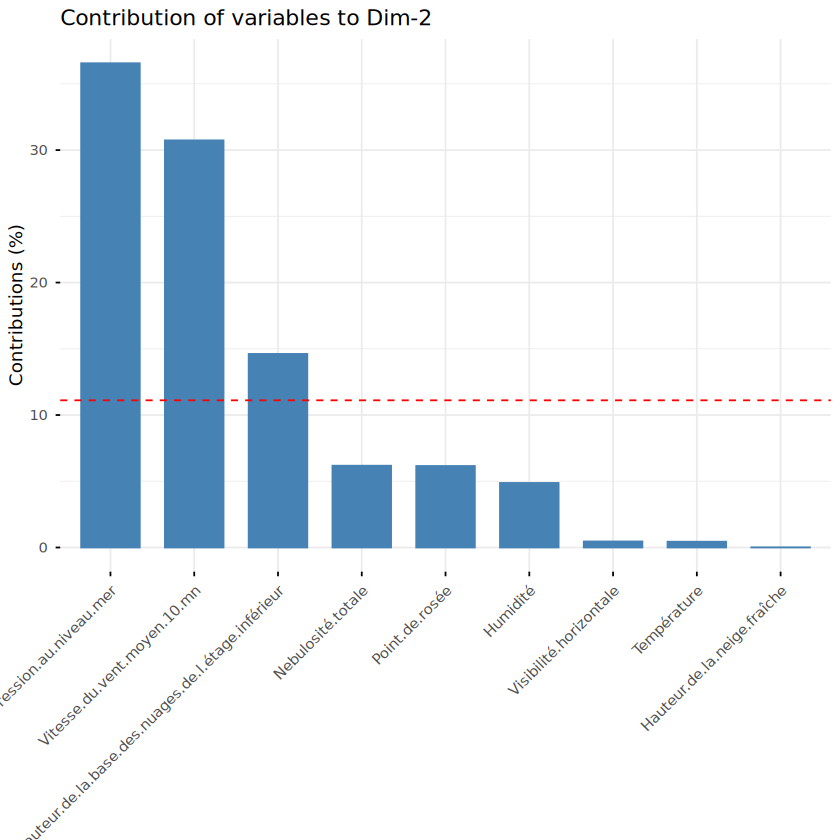

[1] "\n⚑ Interprétation visuelle :\n"
[1] "On voit que Température et humidite sont anti-corrélés donc on va faire afficher les points\n"
[1] "On voit que Visibilité et humidite sont anti-corrélés donc on va faire afficher les points\n"


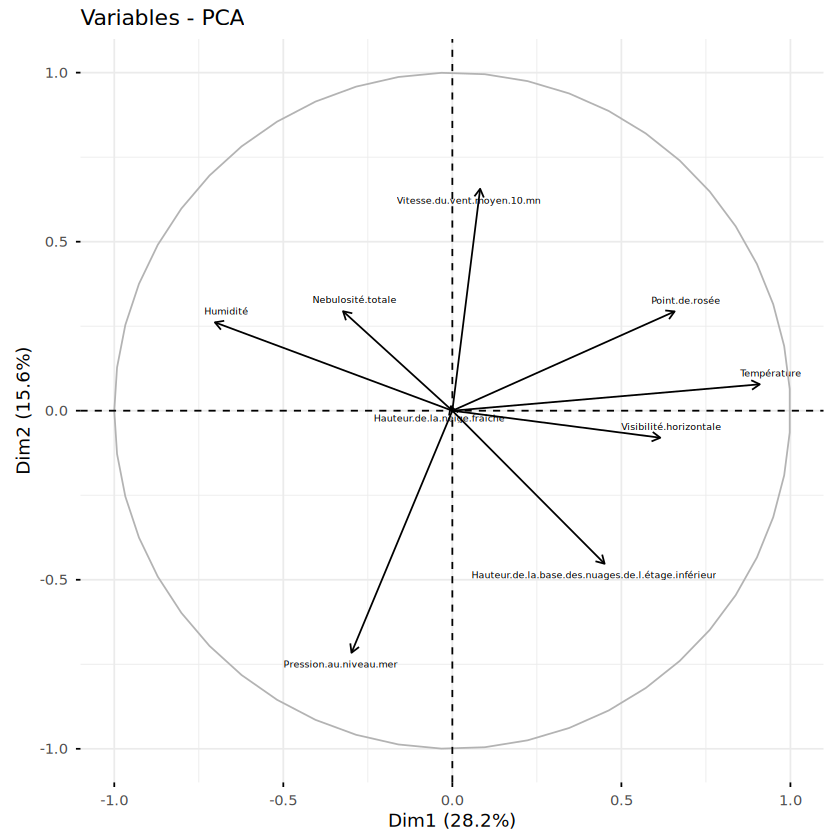

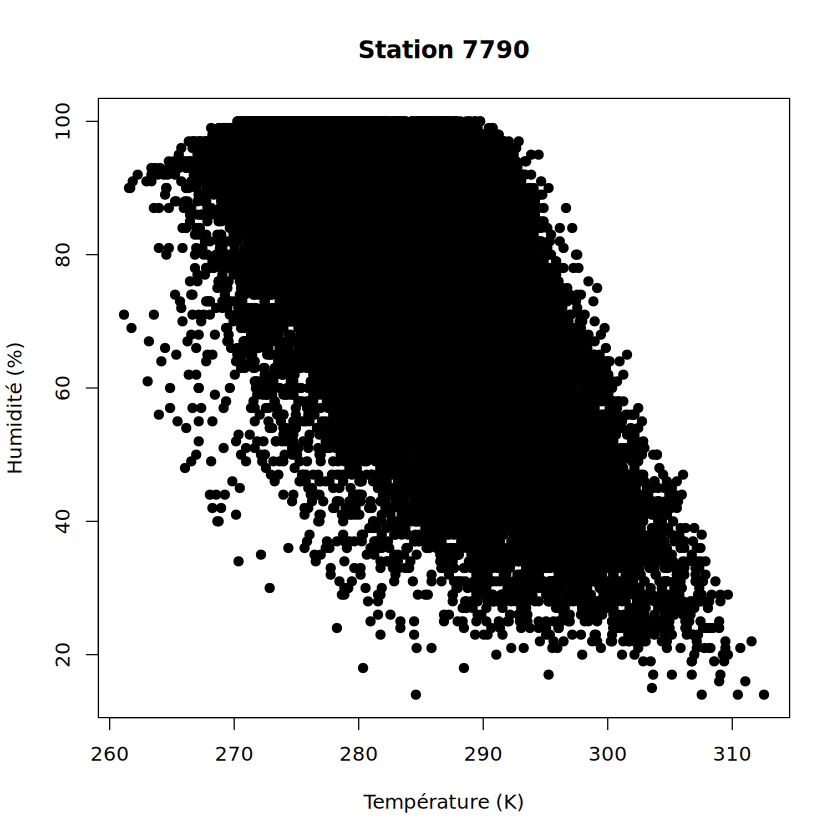

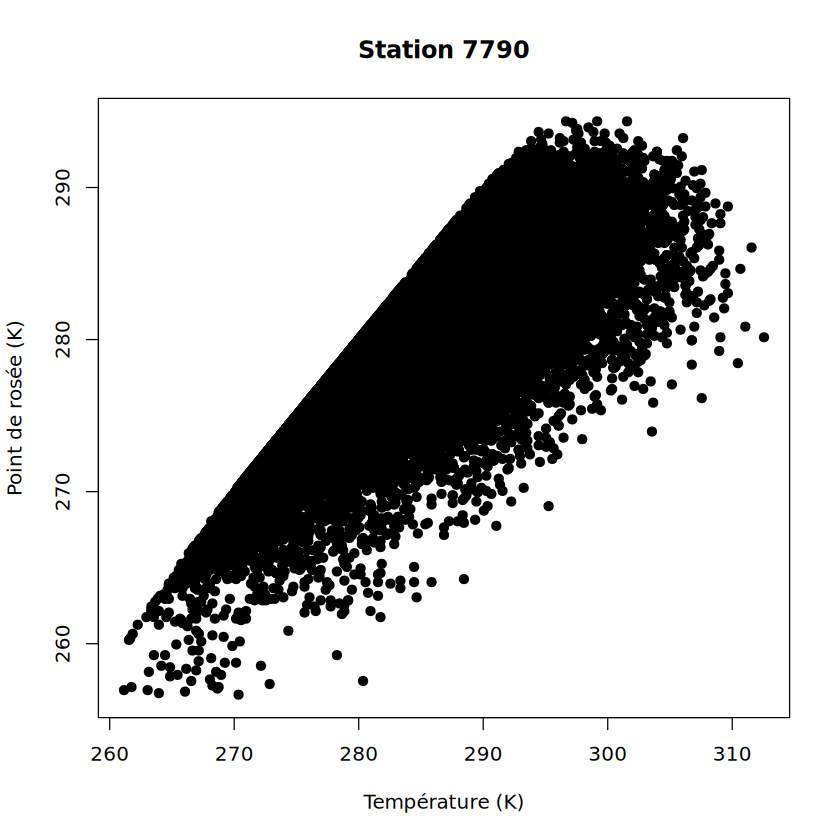

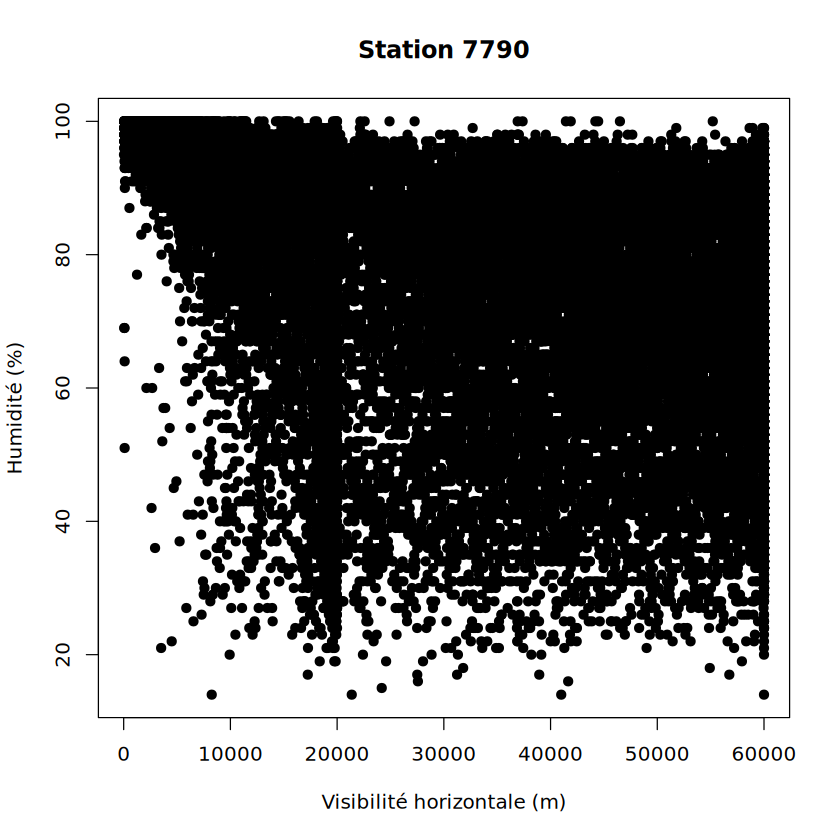

In [25]:

###############################################################################
# 5. PCA 
###############################################################################

#D'abord, calculons la matrice de corrélarion pour voir les relations entre les variables
cor_mat <- cor(df_num, use = "pairwise.complete.obs")  # corrélation entre toutes les variables
round(cor_mat, 2)
library(corrplot)
corrplot(cor_mat, method = "color", type = "upper", tl.cex = 0.7) 

par(bg = "white") 
df_scaled <- scale(df_num)
pca_res <- prcomp(df_scaled, center = TRUE, scale. = TRUE)

# Question : Quelle part de la structure totale est capturée par la PCA ?
print(summary(pca_res))

# 5.1 Quelle est l’importance relative de chaque composante ? (Scree Plot)
plot(pca_res, type = "l", main = "Scree Plot — Variance par composante")

# 5.2 Combien de composantes faut-il pour résumer 70 % / 90 % de la variance ?
var_explained <- cumsum(pca_res$sdev^2 / sum(pca_res$sdev^2))
plot(var_explained, type = "b", pch = 19, 
     xlab = "Nombre de composantes", 
     ylab = "Variance expliquée cumulée",
     main = "Variance expliquée cumulée")
abline(h = 0.7, col = "red", lty = 2)   # Seuil 70 %
abline(h = 0.9, col = "blue", lty = 2)  # Seuil 90 %

# 5.3 À quoi ressemble la structure globale ? (projection des observations)
scores <- pca_res$x
plot(scores[,1], scores[,2],
     xlab = "PC1", ylab = "PC2",
     main = "Projection des observations sur PC1-PC2",
     pch = 19, col = "steelblue")

###############################################################################
# 6. Interprétation des axes — Que représentent PC1 et PC2 ?
###############################################################################

# 6.1 Quelles variables définissent principalement chaque axe ?
loadings <- pca_res$rotation
top_dim1 <- sort(abs(loadings[,1]), decreasing = TRUE)[1:10]
top_dim2 <- sort(abs(loadings[,2]), decreasing = TRUE)[1:10]

cat("\nPC1 est principalement défini par :\n")
print(top_dim1)

cat("\nPC2 est principalement défini par :\n")
print(top_dim2)

fviz_contrib(pca_res, choice = "var", axes = 1, top = 10)
fviz_contrib(pca_res, choice = "var", axes = 2, top = 10)

# 6.2 Conclusion automatique
cat("\n⚑ Interprétation suggérée :\n")
cat("• PC1 oppose :", names(top_dim1[1]), "vs", names(top_dim1[length(top_dim1)]), "\n")
cat("• PC2 oppose :", names(top_dim2[1]), "vs", names(top_dim2[length(top_dim2)]), "\n")

res.pca <- PCA(df_num, scale.unit = TRUE, graph = FALSE)

# Cercle des corrélations pour PC1 et PC2
fviz_pca_var(res.pca, 
             axes = c(1, 2), 
             repel = TRUE, 
             labelsize = 2)
print("\n⚑ Interprétation visuelle :\n")
print("On voit que Température et humidite sont anti-corrélés donc on va faire afficher les points\n")
# TODO : Optionnel -> nommer manuellement les axes (ex : 'Axe Thermique', 'Axe Vent/Humidité')
print("On voit que Visibilité et humidite sont anti-corrélés donc on va faire afficher les points\n")

par(bg = "white")
plot(df_num$`Température`, 
    df_num$`Humidité`, 
    type = "p",
    xlab = "Température (K)", 
    ylab = "Humidité (%)", 
    main = "Station 7790",
    pch = 19,)

plot(df_num$`Température`, 
    df_num$`Point.de.rosée`, 
    type = "p",
    xlab = "Température (K)", 
    ylab = "Point de rosée (K)", 
    main = "Station 7790",
    pch = 19,)

plot(df_num$`Visibilité.horizontale`, 
    df_num$`Humidité`, 
    type = "p",
    xlab = "Visibilité horizontale (m)", 
    ylab = "Humidité (%)", 
    main = "Station 7790",
    pch = 19,)

,Pression.au.niveau.mer,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Nebulosité.totale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Hauteur.de.la.neige.fraîche
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
163,101250,4.3,292.45,284.95,62,22380,90.00000,1250.000,4.761905e-05
233,101110,2.4,277.85,277.55,98,8370,100.00000,150.000,4.761905e-05
326,101120,1.2,279.35,278.75,96,300,97.51436,1502.549,4.761905e-05
563,102820,3.5,284.85,280.75,76,51070,97.51436,1502.549,4.761905e-05
568,101390,2.2,280.55,279.45,93,19940,97.51436,1502.549,4.761905e-05
730,102720,4.9,284.25,283.15,93,13710,100.00000,450.000,4.761905e-05


[1] 0.0378724
[1] 0.1393091
[1] 0.0378724


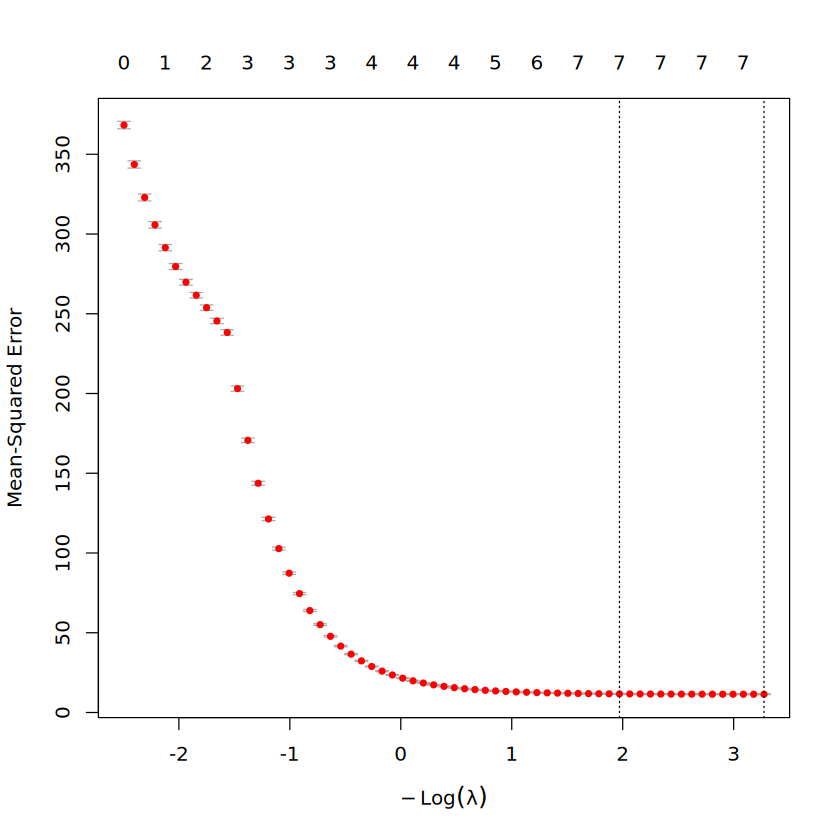

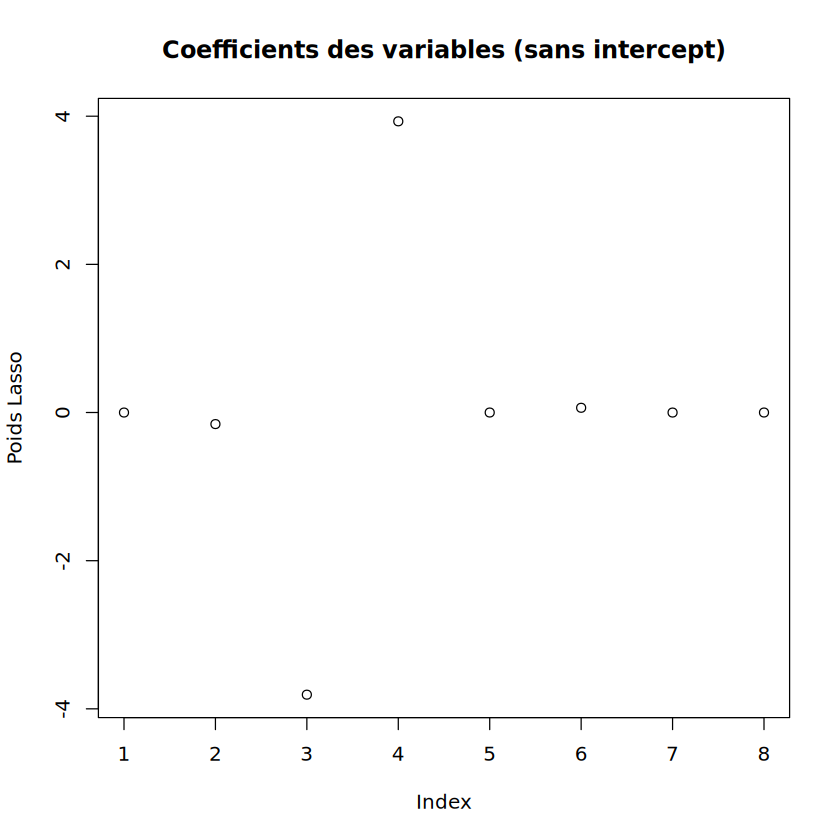

In [28]:
library(glmnet)
head(df_num)
par(bg = "white")
# --- Préparation des données ---
# On enlève l'ID et la Date (pas utiles pour la régression directe)
df_model = df_num
# Variable cible
y <- df_model$`Humidité`

# Variables explicatives
X <- subset(df_model, select = -`Humidité`)

# Conversion en matrice (glmnet attend une matrice numérique)
X_mat <- model.matrix(~., data = X)[,-1]  # supprime l’intercept automatique

# --- Lasso avec validation croisée ---
set.seed(123)  # reproductibilité
cv_lasso <- cv.glmnet(X_mat, y, alpha = 1, nfolds = 10)

# Affiche le lambda optimal
print(cv_lasso$lambda.min)
print(cv_lasso$lambda.1se)

# Tracé de la validation croisée
plot(cv_lasso)

# --- Modèle final avec lambda optimal ---
lasso_model <- glmnet(X_mat, y, alpha = 1, lambda = cv_lasso$lambda.min)
print(cv_lasso$lambda.min)

# Coefficients retenus
coef_lasso <- coef(lasso_model)
# On enlève l'intercept (premier élément)
coef_vars <- as.vector(coef_lasso[-1])
names(coef_vars) <- rownames(coef_lasso)[-1]

# Visualisation des poids
plot(coef_vars, ylab = "Poids Lasso", main = "Coefficients des variables (sans intercept)")
